In [132]:
str = """Patient presents with a recent fall from a cliff approximately 24 hours ago. Since the incident, he has developed a headache, subjective dizziness, and a sensation of altered balance. He denies vomiting or seizures but is concerned about a potential head injury. No visible bleeding was noted at the time of injury. The headache is persistent and moderately severe, and he reports feeling mentally “foggy.”

No loss of consciousness was reported; however, the mechanism of injury (fall from height) raises concern for internal cranial pathology. He also reports systemic symptoms including sore throat and fever, which may or may not be related to the trauma.

Family history includes a report of possible dengue fever and coagulopathy in the patient's father, but the patient has no prior history of bleeding disorders."""

In [133]:
import random
import re

l = []
l.append(str)
osl_shuffled = l

import re

# Assuming lis contains the text data
dataset = osl_shuffled
final_list_of_sentences = []

# Compile the regex patterns once for efficiency
sentence_splitter = re.compile(r'\.\s*')
word_tokenizer = re.compile(r'\b[\w-]+\b')

# Process each text in the dataset
for text in dataset:
    # Split text into sentences and remove empty sentences
    sentences = [sentence.strip() + '.' for sentence in sentence_splitter.split(text) if sentence.strip()]

    # Tokenize, lowercase, and clean each sentence
    tokenized_sentences = [' '.join(word_tokenizer.findall(sentence.lower())) for sentence in sentences]

    # Append the cleaned sentences to the final list
    final_list_of_sentences.append(tokenized_sentences)



for i in range(len(final_list_of_sentences)):
    if not final_list_of_sentences[i]:
        print('Empty')
    final_list_of_sentences[i] = [sentence for sentence in final_list_of_sentences[i] if sentence]

final_list_of_sentences

[['patient presents with a recent fall from a cliff approximately 24 hours ago',
  'since the incident he has developed a headache subjective dizziness and a sensation of altered balance',
  'he denies vomiting or seizures but is concerned about a potential head injury',
  'no visible bleeding was noted at the time of injury',
  'the headache is persistent and moderately severe and he reports feeling mentally foggy',
  'no loss of consciousness was reported however the mechanism of injury fall from height raises concern for internal cranial pathology',
  'he also reports systemic symptoms including sore throat and fever which may or may not be related to the trauma',
  'family history includes a report of possible dengue fever and coagulopathy in the patient s father but the patient has no prior history of bleeding disorders']]

In [134]:
import torch
import torch.nn as nn
import re
from torchcrf import CRF
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel, BertConfig
from download_utils import download_model_if_needed

# Define BiLSTM and MOD classes
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.input_size = 768
        self.hidden_size = 256
        self.num_layers = 2
        self.dropout = 0.3
        self.bilstm = nn.LSTM(input_size=self.input_size, hidden_size=128,
                            num_layers=self.num_layers, batch_first=True,
                            dropout=self.dropout, bidirectional=True)

    def forward(self, embeddings):
        lstm_out, _ = self.bilstm(embeddings)
        return lstm_out

class MOD(nn.Module):
    def __init__(self, input_size, num_labels):
        super(MOD, self).__init__()
        self.bilstm = BiLSTM()
        self.linear = nn.Linear(256, num_labels)
        self.crf = CRF(num_labels)

    def forward(self, x):
        lstm_output = self.bilstm(x)
        embeddings = self.linear(lstm_output)
        return embeddings

# Load BioBERT tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [135]:

import os

# Get the current file's directory (Utils directory)
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory

# Construct paths to the model files
config_path = os.path.join(current_dir, "config.json")
vocab_path = os.path.join(current_dir, "vocab.txt")
model_path = os.path.join(current_dir, "pytorch_model.bin")

# Add the Google Drive URL for your model
GDRIVE_URL = "https://drive.google.com/uc?id=1q43z-Eo_ZE41tpJOhOIbd_WPS0ufDz6j"  

# Download the model if it doesn't exist
model_path = download_model_if_needed(model_path, GDRIVE_URL)
from torch.ao.quantization import quantize_dynamic
config = BertConfig.from_pretrained(config_path)
tokenizer = BertTokenizer.from_pretrained(vocab_path)
biobert_model = BertModel.from_pretrained(model_path, config=config, local_files_only=True)
# biobert_model = quantize_dynamic(
#     biobert_model, {torch.nn.Linear}, dtype=torch.qint8
# )
# Load the trained model
model = MOD(768, 6).to(device)  # Ensure model is on the same device
import os


# Get the current file's directory (Utils directory)
current_dir =os.getcwd()  # Use os.getcwd() to get the current working directory

# Construct path to the model file
model_path = os.path.join(current_dir, "best_model.pth")
# model = quantize_dynamic(
#     model, {torch.nn.Linear}, dtype=torch.qint8
# )
model.load_state_dict(torch.load(model_path, map_location=device))
##

model.eval()

# Initialize lists for storing results
all_symptoms_ALL = []
symptoms_wout_duration_ALL = []
symptom_with_organ_ALL = []
new_dict_ALL = []

organs_list = []
# Assuming final_list_of_sentences is already defined
for i in range(len(final_list_of_sentences)):    
    sentences = final_list_of_sentences[i]
    tsl_tokenized = []

    for sentence in sentences:
        tokens = re.findall(r'\b[\w-]+\b', sentence.lower())
        tsl_tokenized.append(tokens)

    vocab_test = []
    for sentence in tsl_tokenized:
        for token in sentence:
            if token not in vocab_test:
                vocab_test.append(token)

    word_embeddings = []
    for word in vocab_test:
        tokens = tokenizer(word, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = biobert_model(**tokens)
        embedding = outputs.last_hidden_state[0][0]
        word_embeddings.append(embedding)

    word_embeddings_test = torch.stack(word_embeddings).to(device)
    sentence_embeddings_test = []
    each_sentence = []

    for k in range(len(tsl_tokenized)):
        each_word_embeddings_test = []
        for token in tsl_tokenized[k]:
            word_embedding_tensor_test = word_embeddings_test[vocab_test.index(token)]
            each_word_embeddings_test.append(word_embedding_tensor_test)
        sentence_embeddings_test.extend(each_word_embeddings_test)
        each_sentence.append(each_word_embeddings_test)

    pred = []
    for j, sentence in enumerate(each_sentence):
        if len(sentence) == 0:
            continue
        with torch.no_grad():
            print(i, j)
            # Stack the sentence tensors and move them to the device
            sentence_tensor = torch.stack(sentence).to(device).view(1, -1, 768)
            output = model(sentence_tensor)
            prediction = model.crf.decode(output)
            pred.append(prediction)

    # Create lists for different labels
    lis_1 = []
    lis_3 = []
    lis_4 = []
    lis_5 = []

    for i in range(len(pred)):
        l1 = {}
        l3 = {}
        l4 = {}
        l5 = {}
        prediction = pred[i]
        s = ''
        for k in range(len(prediction)):
            if prediction[k][0] != 0:
                s += tsl_tokenized[i][k] + ' '
            elif k != 0 and prediction[k][0] == 0:
                t = prediction[k-1][0]
                if t != 0:
                    if t == 1:
                        l1[s.strip()] = k
                    elif t == 2:
                        l1[s.strip()] = k
                    elif t == 3:
                        l3[s.strip()] = k
                    elif t == 4:
                        l4[s.strip()] = k
                    elif t == 5:
                        l5[s.strip()] = k
            
                    s = ''

                #store the organs in a set??
                organs_list.append(list(l5.keys()))
        if prediction[-1][0] != 0:
            t = prediction[-1][0]
            if t == 1:
                l1[s.strip()] = len(prediction)
            elif t == 2:
                l1[s.strip()] = len(prediction)
            elif t == 3:
                l3[s.strip()] = len(prediction)
            elif t == 4:
                l4[s.strip()] = len(prediction)
            elif t == 5:
                l5[s.strip()] = len(prediction)

        lis_1.append(l1)
        lis_3.append(l3)
        lis_4.append(l4)
        lis_5.append(l5)

    symptoms_wout_duration = []
    for l1 in lis_1:
        if l1:
            for key in l1.keys():
                symptoms_wout_duration.append(key)

    new_dict = {}
    for i in range(len(lis_3)):
        if not lis_3[i]:
            #new_dict_ALL.append(new_dict)
            continue
        for key_3, value_3 in lis_3[i].items():
            closest_key = None
            minimum_difference = float('inf')
            for key_1, value_1 in lis_1[i].items():
                difference = abs(value_3 - value_1)
                if difference < minimum_difference:
                    minimum_difference = difference
                    closest_key = key_1
            new_dict[key_3] = closest_key

    all_symptoms_ALL.append(symptoms_wout_duration)
    symptoms_wout_duration_ALL.append(symptoms_wout_duration)
    new_dict_ALL.append(new_dict)



all_symptoms_ALL = [list(set(lst)) for lst in all_symptoms_ALL]

/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_71480/2089725556.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7


In [136]:


for i in symptoms_wout_duration_ALL:
    if 'headache' in i:
        print(True)


hashset = set()
for i in organs_list:
    if i:
        for j in i:
            hashset.add(j)



True


In [137]:
import string
import re

# Create a set of common words to remove
common_words = set(['a', 'and' 'an', 'the', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 'for', 'and', 'or', 'but', 'with', 'on', 'at', 'as', 'by', 'for', 'with', 'as', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'as', 'until', 'while', 'as', 'until', 'while'])

# Function to clean a single word
def clean_word(word):
    # Remove punctuation and convert to lowercase
    word = word.lower().translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    word = re.sub(r'\d+', '', word)
    return word.strip()

# Clean the hashset
cleaned_hashset = set()
for item in hashset:
    # Split the item into words
    words = item.split()
    # Clean each word and keep only non-common words
    cleaned_words = [clean_word(word) for word in words if clean_word(word) and clean_word(word) not in common_words]
    # Join the cleaned words back together
    cleaned_item = ' '.join(cleaned_words)
    if cleaned_item:  # Only add non-empty items
        cleaned_hashset.add(cleaned_item)



hashset = cleaned_hashset

In [138]:


#CHECK WHETHER A SYMPTOM IS PRESENT IN THE GIVEN SENTENCE
#IF YES: LOOK FOR ORGANS IN THE SENTENCE AND IN THE (i + 1) AND (i - 1) SENTENCES
#JUST EXTRACT THE PAIRS FOR N0W
symp_to_organ_tentative = []
for i in range(len(final_list_of_sentences)):   #EACH CASE
    for t in range(len(final_list_of_sentences[i])):    #SENTENCE IN EACH CASE

        #iterate through the symptoms_wout_duration_ALL list and check for it in i:
        for j in range(len(symptoms_wout_duration_ALL)):
            symptoms_in_case = symptoms_wout_duration_ALL[j]
            for k in range(len(symptoms_in_case)):
                #CHECK FOR THE SYMPTOM IN i
                symptom = symptoms_in_case[k]
                if symptom in final_list_of_sentences[i][t]:
                    #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                    for q in hashset:
                        if q in final_list_of_sentences[i][t]:
                            #MAKE THE SYMPTOM - ORGAN PAIRS:
                            temp = []
                            temp.append(symptom)
                            temp.append(q)
                            symp_to_organ_tentative.append(temp)

                if t- 1 >= 0 and symptom in final_list_of_sentences[i][t - 1] :
                    #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                    for q in hashset:
                        if q in final_list_of_sentences[i][t - 1]:
                            #MAKE THE SYMPTOM - ORGAN PAIRS:
                            temp = []
                            temp.append(symptom)
                            temp.append(q)

                if t + 1 < len(final_list_of_sentences[i]) and symptom in final_list_of_sentences[i][t + 1] :
                    #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                    for q in hashset:
                        if q in final_list_of_sentences[i][t + 1]:
                            #MAKE THE SYMPTOM - ORGAN PAIRS:
                            temp = []
                            temp.append(symptom)
                            temp.append(q)


s = []
for i in symp_to_organ_tentative:
    if i not in s:
        s.append(i)
print(s)
symp_to_organ_tentative = s

l = []
for i in range(len(new_dict_ALL) - 1):
    if new_dict_ALL[i] != new_dict_ALL[i + 1]:
        l.append(new_dict_ALL[i])

l.append(new_dict_ALL[len(new_dict_ALL) - 1])

symptom_with_duration_ALL = l
symptom_with_duration_ALL

[['injury', 'cranial'], ['loss of consciousness', 'cranial'], ['height', 'cranial']]


[{}]

In [139]:


time_units = ['seconds', 'minutes', 'hours', 'days', 'months', 'years', 'decades']

def replace_keys(data, time_units):
    new_data = []
    for item in data:
        new_item = {}
        for key, value in item.items():
            matched_word = next((unit for unit in time_units if unit in key), None)
            if matched_word and value is not None:
                new_item[matched_word] = value
        new_data.append(new_item)
    return new_data

updated_data = replace_keys(symptom_with_duration_ALL, time_units)
print(updated_data)

symptom_with_duration_ALL = updated_data
symptom_with_duration_ALL

[{}]


[{}]

In [140]:


symptom_duration_map = {}
for duration_dict in symptom_with_duration_ALL:
    for duration, symptom in duration_dict.items():
        symptom_duration_map[symptom] = duration

# Combine the lists to create the final output
combined_list = []
for symptom in symptoms_wout_duration_ALL[0]:
    # Get the duration for the current symptom, or 'nil duration' if not found
    duration = 'nil duration'
    for key in symptom_duration_map:
        if key in symptom:
            duration = symptom_duration_map[key]
            break

    # Find all organs associated with the symptom, or 'nil organ' if no association is found
    found_organ = False
    for symp, organ in symp_to_organ_tentative:
        if symptom == symp:
            combined_list.append([symptom, duration, organ])
            found_organ = True

    # If no organ was found for the symptom, add 'nil organ'
    if not found_organ:
        combined_list.append([symptom, duration, 'nil organ'])


In [141]:


duration_mapping = {
    'seconds': 2,
    'minutes': 3,
    'hours': 4,
    'days': 5,
    'months': 6,
    'years': 7,
    'decades': 8,
    'nil duration': 1
}

# Update the second element in each sublist
for lis in combined_list:
    lis[1] = duration_mapping[lis[1]]

# Convert each sublist to a tuple
for i in range(len(combined_list)):
    combined_list[i] = tuple(combined_list[i])


combined_list


[('headache', 1, 'nil organ'),
 ('dizziness', 1, 'nil organ'),
 ('altered balance', 1, 'nil organ'),
 ('vomiting', 1, 'nil organ'),
 ('seizures', 1, 'nil organ'),
 ('head injury', 1, 'nil organ'),
 ('bleeding', 1, 'nil organ'),
 ('injury', 1, 'cranial'),
 ('headache', 1, 'nil organ'),
 ('mentally foggy', 1, 'nil organ'),
 ('loss of consciousness', 1, 'cranial'),
 ('injury', 1, 'cranial'),
 ('height', 1, 'cranial'),
 ('symptoms', 1, 'nil organ'),
 ('sore throat', 1, 'nil organ'),
 ('fever', 1, 'nil organ'),
 ('trauma', 1, 'nil organ'),
 ('dengue fever', 1, 'nil organ'),
 ('coagulopathy', 1, 'nil organ'),
 ('bleeding disorders', 1, 'nil organ')]

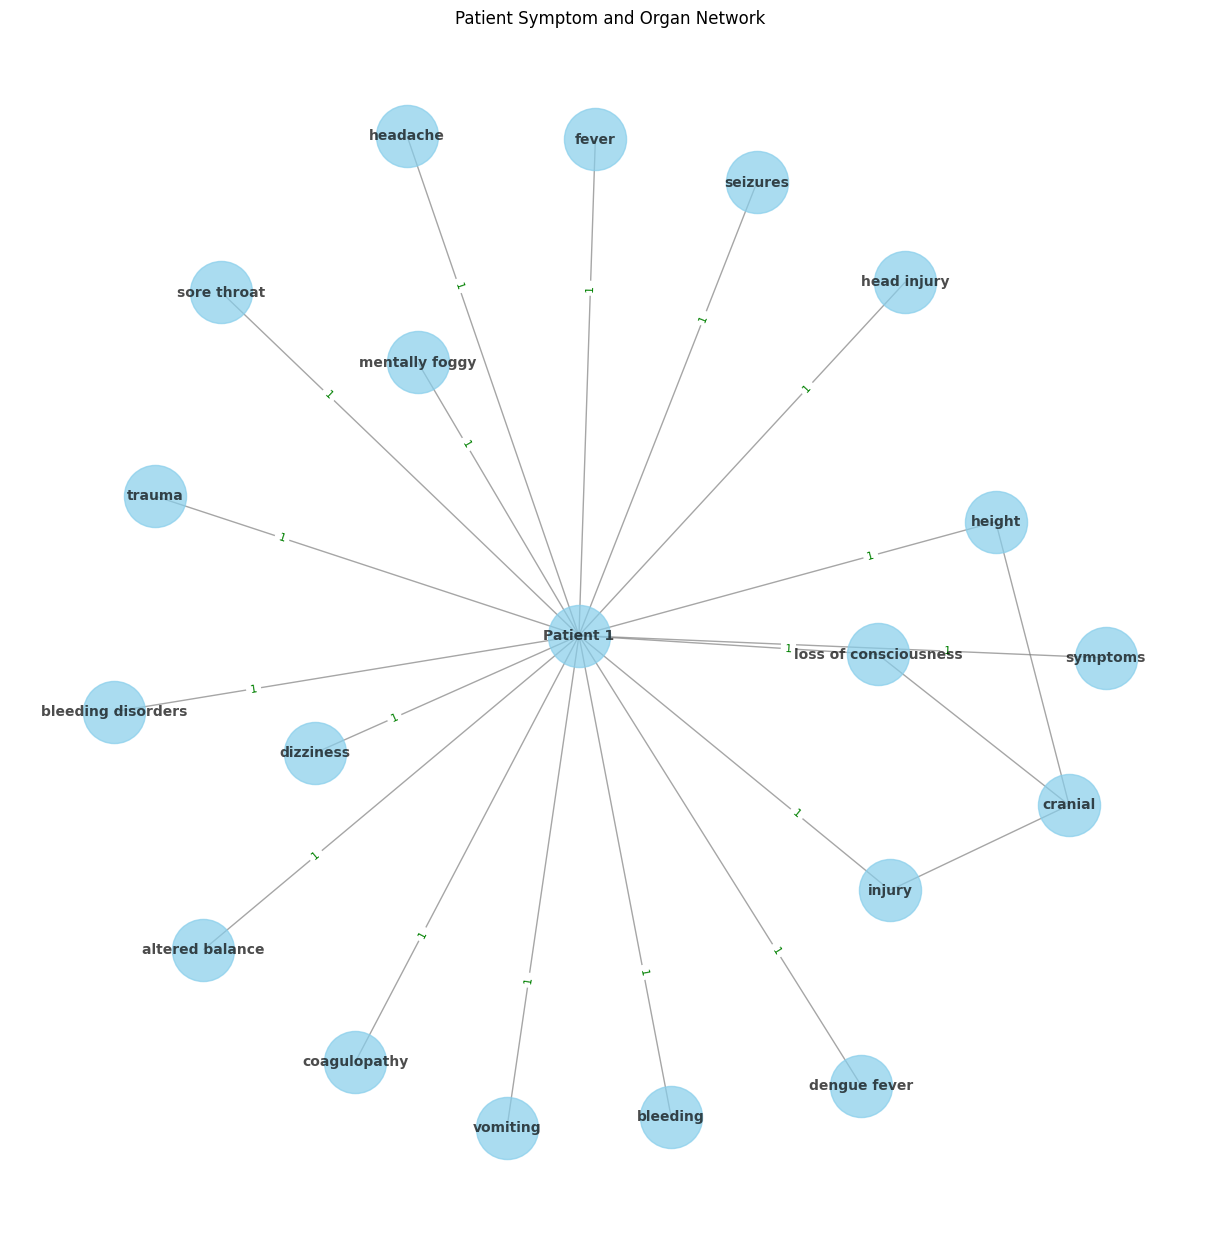

In [142]:

import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph for the patient
G = nx.Graph()

# Add a central node for the patient
patient_node = 'Patient 1'
G.add_node(patient_node, label='Patient')

# Add nodes for symptoms and organs, and connect them to the patient node
for symptom, duration, organ in combined_list:
    # Add symptom node and connect to patient
    G.add_node(symptom, label='Symptom')
    G.add_edge(patient_node, symptom)

    # Add organ node if it is specified and connect to the symptom
    if organ != 'nil organ':
        G.add_node(organ, label='Organ')
        G.add_edge(symptom, organ)

    # Optional: Set edge weights based on symptom durations (if applicable)
    if duration != 'nil duration':
        G[patient_node][symptom]['weight'] = duration

# Function to plot the graph
def plot_graph(G):
    pos = nx.spring_layout(G, k=0.5, scale=2)  # Adjust k and scale for better spacing
    plt.figure(figsize=(12, 12))  # Adjust figure size for better display
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', alpha=0.7, edge_color='gray')

    # Draw edge labels and weights
    weights = nx.get_edge_attributes(G, 'weight')
    if weights:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color='green', font_size=8, label_pos=0.3)

    plt.title('Patient Symptom and Organ Network')
    plt.show()

# Plot the graph
plot_graph(G)


In [143]:


from transformers import BertTokenizer, BertModel, BertConfig
import torch
import torch.nn as nn
import re
from torchcrf import CRF
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel, BertConfig
import os
from download_utils import download_model_if_needed

# Get the current file's directory (Utils directory)
current_dir = os.getcwd()

# Construct paths to the model files
config_path = os.path.join(current_dir, "config.json")
vocab_path = os.path.join(current_dir, "vocab.txt")
model_path = os.path.join(current_dir, "pytorch_model.bin")

# Add the Google Drive URL for your model
GDRIVE_URL = "https://drive.google.com/uc?id=1q43z-Eo_ZE41tpJOhOIbd_WPS0ufDz6j"

# Download the model if it doesn't exist
model_path = download_model_if_needed(model_path, GDRIVE_URL)

config = BertConfig.from_pretrained(config_path)
tokenizer = BertTokenizer.from_pretrained(vocab_path)
biobert_model = BertModel.from_pretrained(model_path, config=config, local_files_only=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [144]:


feature_matrices = []


matrix = [None] * len(G.nodes())  # Initialize a list to store embeddings in the correct order

edge_list = list(G.edges())
unique_nodes = sorted(set(G.nodes()))  # Ensure all nodes are included and sorted

node_mapping = {node: i for i, node in enumerate(unique_nodes)}  # Mapping nodes to indices

for node in G.nodes():
    if node not in node_mapping:
        print(f"Node '{node}' not found in node_mapping.")
        continue

    print(node)
    text = node  # Text to be tokenized
    # inputs = tokenizer(text, return_tensors='pt').to(device)

    # with torch.no_grad():
    #     outputs = biobert_model(**inputs)
    #     embeddings = outputs.last_hidden_state

    # Averaging the embeddings
    #averaged_matrix = embeddings[0].mean(dim=0).view(1, -1)

    # Place the embedding in the correct row based on the node_mapping

    inputs = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = biobert_model(**inputs)
        embeddings = outputs.last_hidden_state

    # Averaging the embeddings
    averaged_matrix = embeddings[0].mean(dim=0).view(1, -1)
    matrix[node_mapping[node]] = averaged_matrix


# Remove None entries (if any) and convert the list to a tensor
matrix = torch.cat([m for m in matrix if m is not None], dim=0)  # (num_nodes, hidden_size)
feature_matrices.append(matrix)

print(feature_matrices)


Patient 1
headache
dizziness
altered balance
vomiting
seizures
head injury
bleeding
injury
cranial
mentally foggy
loss of consciousness
height
symptoms
sore throat
fever
trauma
dengue fever
coagulopathy
bleeding disorders
[tensor([[ 0.3019, -0.0280, -0.2518,  ..., -0.0707,  0.2164, -0.1463],
        [ 0.2552, -0.2072, -0.2135,  ..., -0.7301,  0.4210, -0.2451],
        [ 0.2094, -0.0480, -0.1328,  ..., -0.6319,  0.5156, -0.1279],
        ...,
        [ 0.3548, -0.2514, -0.2671,  ..., -0.6230,  0.5903, -0.1170],
        [ 0.2190, -0.0727, -0.1276,  ..., -0.4786,  0.4227,  0.0291],
        [ 0.0119, -0.0797, -0.2473,  ..., -0.3274,  0.4346, -0.0311]])]


In [145]:

main_edge_list = []
lis = []


matrix = []
print(G.nodes)

edge_list = list(G.edges())
unique_nodes = sorted(set(node for edge in edge_list for node in edge))  # Sort the unique nodes

# Create a mapping from node labels to integers in a sorted order
node_mapping = {node: i for i, node in enumerate(unique_nodes)}

# Convert edge list to numeric representation
numeric_edge_list = [[node_mapping[u], node_mapping[v]] for u, v in edge_list]

# Create tensor and move to the appropriate device
edge_tensor = torch.tensor(numeric_edge_list, dtype=torch.long).to(device)
lis.append(edge_tensor)

# Store the edge list in main_edge_list
main_edge_list.append(edge_list)



['Patient 1', 'headache', 'dizziness', 'altered balance', 'vomiting', 'seizures', 'head injury', 'bleeding', 'injury', 'cranial', 'mentally foggy', 'loss of consciousness', 'height', 'symptoms', 'sore throat', 'fever', 'trauma', 'dengue fever', 'coagulopathy', 'bleeding disorders']


In [146]:




import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SortAggregation
from torch_geometric.data import Data
import torch.optim as optim
import numpy as np
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GCN_SortPool_CNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, k):
        super(GCN_SortPool_CNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.sort_pool = SortAggregation(k=k) #prioritizing nodes (dk what k is)
        self.cnn1d = nn.Conv1d(in_channels=hidden_channels, out_channels=32, kernel_size=2)
    
        # Calculate the correct input size for the fully connected layer
        cnn_output_size = 32 * (k - 1)  # Because kernel_size=2 reduces length by 1
        self.fc = nn.Linear(cnn_output_size, out_channels)
    
    def forward(self, x, edge_index):
        # GCN Layers
        x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
    
        # SortPooling
        x = self.sort_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))  # Create a dummy batch tensor
    
        # Reshape for 1D CNN
        x = x.view(x.size(0), -1, self.sort_pool.k)  # Reshape to (batch_size, hidden_channels, k)
    
        # 1D CNN
        x = F.relu(self.cnn1d(x))
        x = x.view(x.size(0), -1)  # Flatten
    
        # Fully Connected + Sigmoid
        x = self.fc(x)
        x = torch.sigmoid(x)  # Apply sigmoid activation
        return x

# Load the model
model = GCN_SortPool_CNN(in_channels=768, hidden_channels=32, out_channels=1, k=14).to(device)

import os

# Get the current file's directory (Utils directory)
current_dir = os.getcwd()

# Construct path to the model file
model_path = os.path.join(current_dir, "gcn_sortpool_cnn.pth")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
pred_1 = [0]
pred_1_shuffled = [0]
# Create a list of Data objects for the test data
graphs = [Data(x=feature_matrices[i].to(device), edge_index=lis[i].to(device)) for i in range(len(feature_matrices))]
#print(len(pred_1))
# Perform inference
with torch.no_grad():
    predictions = []
    targets = []
    c=0
    for i, graph in enumerate(graphs):
        c+=1
        if c>44:
            break
        output = model(graph.x, graph.edge_index.view(2, -1))
        predicted = (output > 0.5).float()  # Convert probabilities to binary predictions
        predictions.append(predicted.cpu().numpy())  # Move output to CPU and convert to numpy array
        targets.append(pred_1_shuffled[i])  # Collect the targets

# Convert lists to numpy arrays for easy comparison
predictions = np.array(predictions).flatten()  # Flatten to match target shape
targets = np.array(targets).flatten()  # Flatten to match prediction shape

# Calculate number of correct predictions
correct_predictions = np.sum(predictions == targets)
total_predictions = len(targets)
accuracy = correct_predictions / total_predictions

# Output number of correct predictions, accuracy, and predictions
# print(f"Number of correct predictions: {correct_predictions}")
# print(f"Accuracy: {accuracy:.4f}")

q = -1
for i, (pred, target) in enumerate(zip(predictions, targets)):
    # print(f"Graph {i} - Prediction: {pred}, Target: {target}")
    q = pred

s = ""
if q == 0:
    s = "MRI NOT REQUIRED"
elif q == 1:
    s = "MRI NEEDED NOW !!!"
else:
    s = "PREDICTION_NEEDED"


[('', s)]

/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_71480/2294230845.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

[('', 'MRI NEEDED NOW !!!')]